# Importing Global Library

In [73]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc

from keras.models import Sequential
from keras import layers

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) == 0:
    print("No GPU devices found.")
else:
    print("GPU devices found:", physical_devices)

GPU devices found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Global Variables

In [3]:
RANDOM_STATE=42

# Helper Functions

In [71]:
def performance_matrices(
    model,
    X_train,
    X_test,
    y_train,
    y_test,
    verbose=True
):
    y_train_pred = (model.predict(X_train) > 0.5).astype("int32")
    y_test_pred = (model.predict(X_test) > 0.5).astype("int32")


    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_pred)


    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    ret_dict = {
        'train': {
            'accuracy': accuracy_train,
            'precision': precision_train,
            'recall': recall_train,
            'f1': f1_train,
            'auc': auc_train
        },
        'test': {
            'accuracy': accuracy_test,
            'precision': precision_test,
            'recall': recall_test,
            'f1': f1_test,
            'auc': auc_test
        }
    }

    if verbose:
        print("Training Accuracy: {:.4f}".format(accuracy_train))
        print("Training Precision: {:.4f}".format(precision_train))
        print("Training Recall: {:.4f}".format(recall_train))
        print("Training F1 Score: {:.4f}".format(f1_train))
        print("Training AUC Score: {:.4f}".format(auc_train))
        print('-'*50)

        print("Testing Accuracy:  {:.4f}".format(accuracy_test))
        print("Testing Precision: {:.4f}".format(precision_test))
        print("Testing Recall: {:.4f}".format(recall_test))
        print("Testing F1 Score: {:.4f}".format(f1_test))
        print("Testing AUC Score: {:.4f}".format(auc_test))

    return ret_dict

In [5]:
def plot_confution_matrix(
    model,
    X_train,
    X_test,
    y_train,
    y_test,
    model_name,
    show_img=True,
    save_img=False,
    save_path=None,
    fig_size=(12, 5)
):
    y_train_pred = (model.predict(X_train) > 0.5).astype("int32")
    y_test_pred = (model.predict(X_test) > 0.5).astype("int32")

    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'{model_name} Confusion Matrix', fontsize=16)

    # Training Set
    sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
    axes[0].set_title('Training Set Confusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')

    # Testing Set
    sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
    axes[1].set_title('Testing Set Confusion Matrix')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    if save_img:
        plt.savefig(save_path)

    if show_img:
        plt.show()

In [ ]:
def plot_roc_curve(
    model,
    X_train,
    X_test,
    y_train,
    y_test,
    model_name,
    show_img=True,
    save_img=False,
    save_path=None,
    fig_size=(12, 5)
):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)

    roc_auc_train = auc(fpr_train, tpr_train)
    roc_auc_test = auc(fpr_test, tpr_test)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'{model_name} ROC Curve', fontsize=16)

    # Training Set
    axes[0].plot(fpr_train, tpr_train, label=f'ROC Curve (area = {roc_auc_train:.2f})')
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Training Set ROC Curve')
    axes[0].legend(loc='lower right')

    # Testing Set
    axes[1].plot(fpr_test, tpr_test, label=f'ROC Curve (area = {roc_auc_test:.2f})')
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Testing Set ROC Curve')
    axes[1].legend(loc='lower right')

    if save_img:
        plt.savefig(save_path)

    if show_img:
        plt.show()

# Loading Datasets
### *1. Load the dataset you downloaded using Pandas.*


## 1.1. Importing Library

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
!mkdir -p dataset

## 1.2.1. Downloading Dataset from Google Drive

In [8]:
!gdown 1hyn6U44cvUNedMnzPHzHsiBgXMHFBjBw -O dataset/imdb_440.zip
!unzip -o dataset/imdb_440.zip -d dataset
dataset_path = '/content/dataset/IMDB Dataset.csv'
!gdown 1CLrwskD-M8ce0M5agxRjB3OhKuKiCcCn -O dataset/glove.6B.100d.txt
glove_path = '/content/dataset/glove.6B.100d.txt'

Downloading...
From: https://drive.google.com/uc?id=1hyn6U44cvUNedMnzPHzHsiBgXMHFBjBw
To: /content/dataset/imdb_440.zip
100% 27.0M/27.0M [00:00<00:00, 182MB/s]
Archive:  dataset/imdb_440.zip
  inflating: dataset/IMDB Dataset.csv  
Downloading...
From: https://drive.google.com/uc?id=1CLrwskD-M8ce0M5agxRjB3OhKuKiCcCn
To: /content/dataset/glove.6B.100d.txt
100% 347M/347M [00:01<00:00, 192MB/s]


## 1.2.2. Uploading Dataset Manually

In [9]:
dataset_path = '/content/dataset/IMDB Dataset.csv'
glove_path = '/content/dataset/glove.6B.100d.txt'

if not os.path.exists(dataset_path) or not os.path.exists(glove_path):
  raise FileNotFoundError()

## 1.3. Parsing Data by Pandas

In [10]:
df = pd.read_csv(dataset_path)

In [11]:
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [12]:
X = df['review']
y = df['sentiment']

## 1.4. Label Encoding

In [13]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Glove Word Embeddings
### *2. Use a pretrained representation technique to convert the reviews into vectors. You should have already downloaded the GloVe vectors). Use GloVe. The tutorial given will have a section on how to convert the reviews to vectors using GloVe.*


## 2.1. Importing Library

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 2.2. Helper Function

In [15]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

## 2.3. Tokenizer

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X_tokenize = tokenizer.texts_to_sequences(X)
vocab_size = len(tokenizer.word_index) + 1

In [17]:
print(X[2])
print(X_tokenize[2])

I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.
[10, 190, 11, 13, 3, 393, 95, 5, 1155, 55, 20, 3, 96, 879, 1494, 2657, 12

In [18]:
for word in ['the', 'all', 'happy', 'sad']:
  print('{}: {}'.format(word, tokenizer.word_index[word]))

the: 1
all: 29
happy: 673
sad: 625


## 2.4. Padding

In [19]:
maxlen = 100

X_pad = pad_sequences(X_tokenize, padding='post', maxlen=maxlen)

In [20]:
print(X_pad[0, :])

[   34  1637     9    13  2239    10   413   131    10    13  1592    15
     9    18    14    10   287    51    10  1417     3  1280    15  3184
     2   189 10168     5     1   299  2046     4  2150   570    21    39
   570    18  7658  7154  5010 13497    26  2983    41    15     3 25422
  6904 13497   504    20   642     2    76   243    16     9    69  7598
   651   710  6904   109   662    82  1208 19395   693     5    65   574
     4   920  2021    38  1208   559   147  3184    22   200   426  3819
    16    48     6  3314   805  1603    43    22    67    76     8  1228
    16   125  4103   486]


## 2.5. Word Embedding

In [21]:
embedding_dim = 100

embedding_matrix = create_embedding_matrix(
    glove_path,
    tokenizer.word_index,
    embedding_dim
)

In [22]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
per_of_nonzero_ele = nonzero_elements / vocab_size
print(f'Percentage of Non-zero Elements: {per_of_nonzero_ele:0.04f}')

Percentage of Non-zero Elements: 0.6044


In [23]:
embedding_matrix_len = len(embedding_matrix)
print(f'Length of Embedding Matrix: {embedding_matrix_len}')

Length of Embedding Matrix: 124253


# Split Data Into Train And Test
### *3. Split the data into two parts, training and testing. You will train a machine learning model on the training part of the data, and then you will test its performance on the test part of the data. Use an 80-20 split for your data, that is, 80% of the data will be for training and 20% of the data will be for testing.*

## 3.1. Importing Library

In [24]:
from sklearn.model_selection import train_test_split

## 3.2. Train and Test Splitting

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_pad,
    y_encoded,
    test_size=0.2,
    random_state=RANDOM_STATE
)

# Training Model
### *4. Train it for 20 epochs once and then test. You can play with the hyperparameters like changing the batch size etc.*


## 4.1. Importing Library

In [63]:
from sklearn.naive_bayes import ComplementNB

## 4.2. Training Model

In [64]:
CNB = ComplementNB()
CNB.fit(X_train, y_train)

ComplementNB()

## 4.3. Evaluating Model

In [88]:
cnb_performance_matrices_dict = performance_matrices(
    CNB,
    X_train,
    X_test,
    y_train,
    y_test,
    verbose=True
)

Training Accuracy: 0.5235
Training Precision: 0.5202
Training Recall: 0.5830
Training F1 Score: 0.5498
Training AUC Score: 0.5237
--------------------------------------------------
Testing Accuracy:  0.5149
Testing Precision: 0.5166
Testing Recall: 0.5807
Testing F1 Score: 0.5468
Testing AUC Score: 0.5144


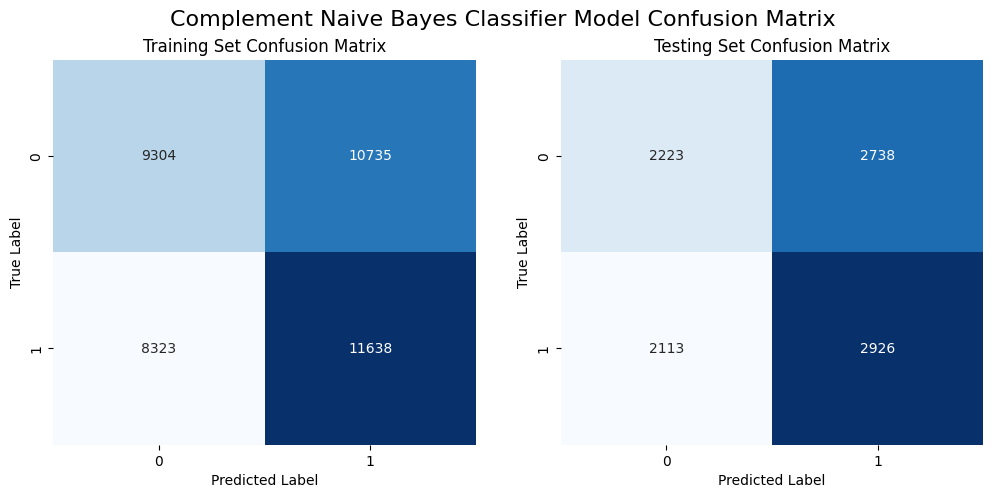

In [66]:
plot_confution_matrix(
    CNB,
    X_train,
    X_test,
    y_train,
    y_test,
    model_name='Complement Naive Bayes Classifier Model',
    show_img=True
)

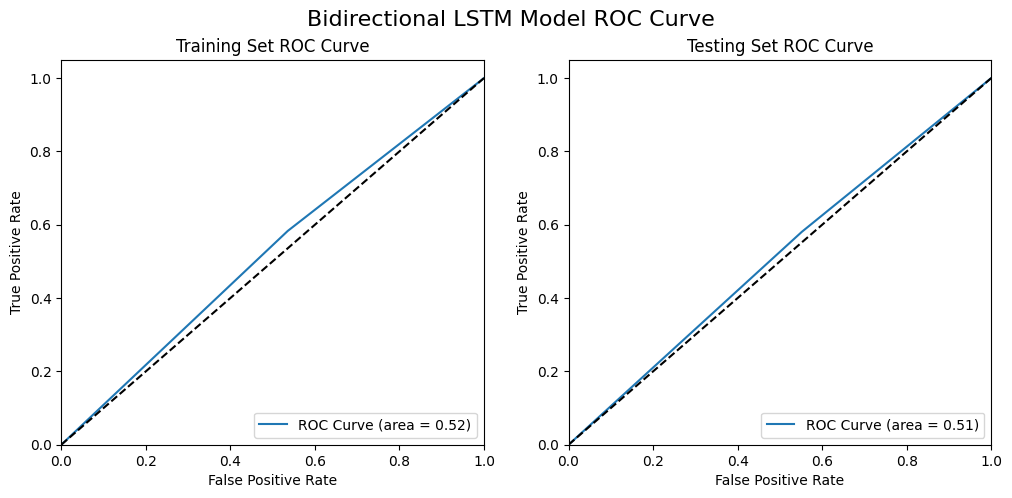

In [78]:
plot_roc_curve(
    CNB,
    X_train,
    X_test,
    y_train,
    y_test,
    model_name='Complement Naive Bayes Classifier',
    show_img=True
)

# Trainning a Shallow Model
### *5. Now, train the shallow model. Use the tutorial given in the preamble. Your model will have three layers: one embedding layer with output shape 100 which will convert your words to a 100-length vector (find GloVe for 100 dimensions), one dense layer with an output shape 10, and the final output layer (another dense layer) with output shape. Do not use any pooling or any other layer.*


## 5.1. Model Defining

In [67]:
shallow_model = Sequential()

shallow_model.add(
    layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=maxlen
    )
)
shallow_model.add(layers.Flatten())
shallow_model.add(layers.Dense(10, activation='relu'))
shallow_model.add(layers.Dense(1, activation='sigmoid'))

shallow_model.compile(
    optimizer='RMSprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

shallow_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          12425300  
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 10)                100010    
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 12525321 (47.78 MB)
Trainable params: 12525321 (47.78 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 5.2. Model Trainning

In [68]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [69]:
shallow_model_history = shallow_model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=True,
    validation_split=0.2,
    batch_size=4096,
    callbacks=[early_stopping]
)

Epoch 1/100
8/8 [==============================] - 3s 221ms/step - loss: 0.6925 - accuracy: 0.5172 - val_loss: 0.6918 - val_accuracy: 0.5332
Epoch 2/100
8/8 [==============================] - 1s 139ms/step - loss: 0.6894 - accuracy: 0.5676 - val_loss: 0.6895 - val_accuracy: 0.5674
Epoch 3/100
8/8 [==============================] - 1s 103ms/step - loss: 0.6841 - accuracy: 0.6289 - val_loss: 0.6833 - val_accuracy: 0.6004
Epoch 4/100
8/8 [==============================] - 1s 104ms/step - loss: 0.6723 - accuracy: 0.6638 - val_loss: 0.6681 - val_accuracy: 0.6574
Epoch 5/100
8/8 [==============================] - 1s 110ms/step - loss: 0.6501 - accuracy: 0.6958 - val_loss: 0.6434 - val_accuracy: 0.6756
Epoch 6/100
8/8 [==============================] - 1s 143ms/step - loss: 0.6174 - accuracy: 0.7170 - val_loss: 0.6064 - val_accuracy: 0.7174
Epoch 7/100
8/8 [==============================] - 1s 135ms/step - loss: 0.5783 - accuracy: 0.7448 - val_loss: 0.5714 - val_accuracy: 0.7325
Epoch 8/100
8

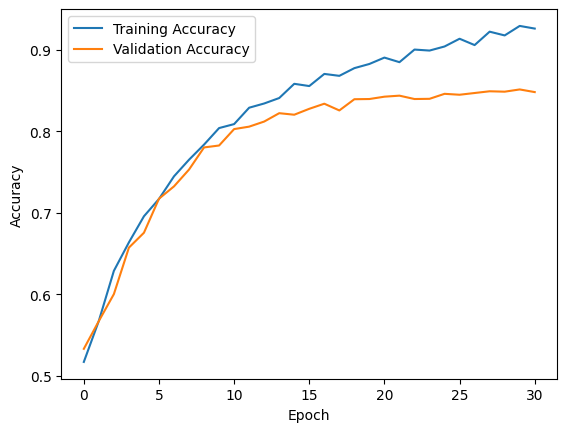

In [70]:
plt.plot(shallow_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(shallow_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## 5.3. Evaluating Model

In [89]:
performance_matrices_dict = performance_matrices(
    shallow_model,
    X_train,
    X_test,
    y_train,
    y_test,
    verbose=True
)

313/313 [==============================] - 1s 2ms/step
Training Accuracy: 0.9117
Training Precision: 0.9270
Training Recall: 0.8933
Training F1 Score: 0.9099
Training AUC Score: 0.9116
--------------------------------------------------
Testing Accuracy:  0.8483
Testing Precision: 0.8661
Testing Recall: 0.8268
Testing F1 Score: 0.8460
Testing AUC Score: 0.8485


313/313 [==============================] - 1s 3ms/step


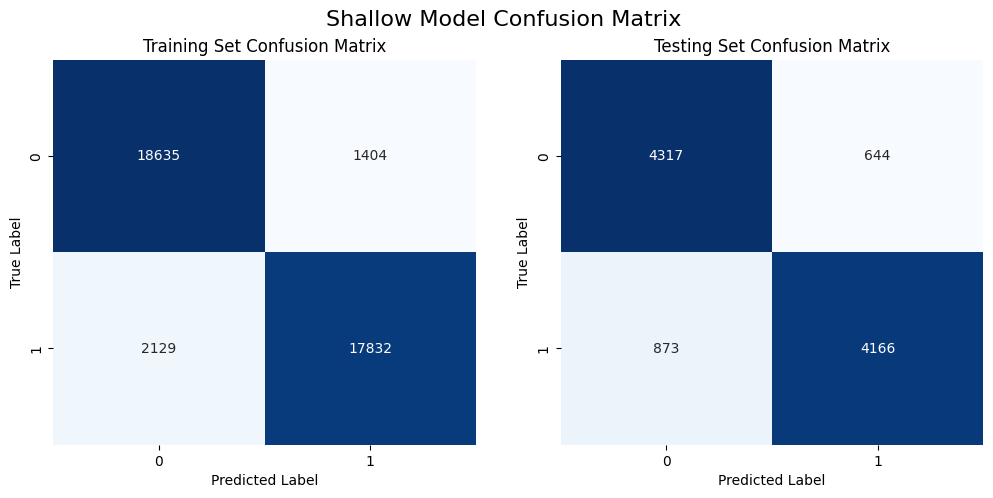

In [80]:
plot_confution_matrix(
    shallow_model,
    X_train,
    X_test,
    y_train,
    y_test,
    model_name='Shallow Model',
    show_img=True
)

313/313 [==============================] - 1s 2ms/step


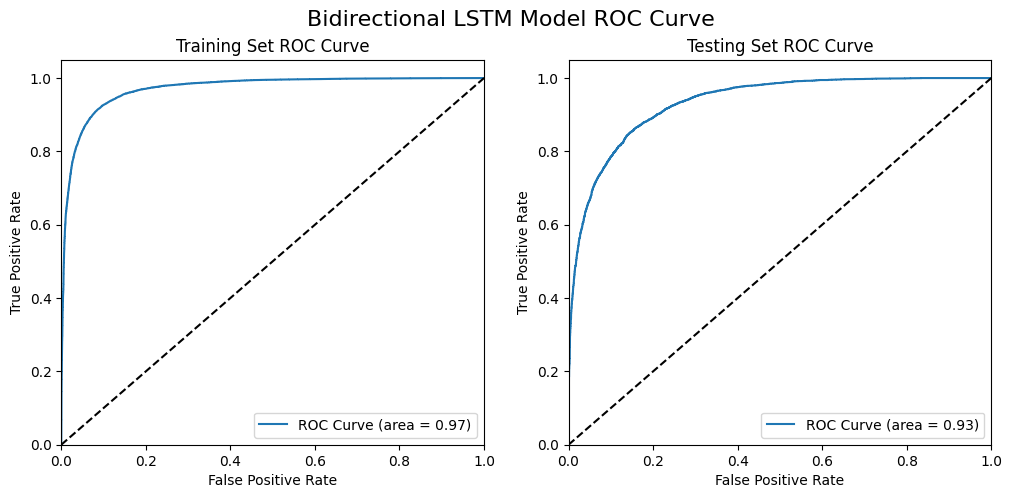

In [81]:
plot_roc_curve(
    shallow_model,
    X_train,
    X_test,
    y_train,
    y_test,
    model_name='Shallow Model',
    show_img=True
)

# LSTM
### *6. Now, let’s improve the model by introducing gated recurrence relation to it. In the previous neural net structure, there were no gates-- it was one dense (fully connected) sequential layer after another. Now, instead of the first dense layer, let’s use an LSTM. Replace the first dense layer (that was taking input from the embedding layer and producing a 10-sized output) with an appropriate LSTM layer (you can find hundreds of tutorials on how to do that online, for example, this one is great). We will experiment with two versions of this:*
### *a. A single unidirectional LSTM layer*
### *b. A single bidirectional LSTM layer*


## 6.1. A single unidirectional LSTM layer

### 6.1.1. Model Defining

In [42]:
unidir_lstm_model = Sequential()

unidir_lstm_model.add(
    layers.Embedding(
        vocab_size,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=True
    )
)

unidir_lstm_model.add(layers.LSTM(10, activation='tanh'))
unidir_lstm_model.add(layers.Dense(1, activation='sigmoid'))

unidir_lstm_model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

unidir_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          12425300  
                                                                 
 lstm_1 (LSTM)               (None, 10)                4440      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 12429751 (47.42 MB)
Trainable params: 12429751 (47.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 6.1.2 Model Trainning

In [43]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [44]:
unidir_lstm_model_history = unidir_lstm_model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=True,
    validation_split=0.2,
    batch_size=4096,
    callbacks=[early_stopping]
)

Epoch 1/100
8/8 [==============================] - 3s 186ms/step - loss: 0.7000 - accuracy: 0.4942 - val_loss: 0.6920 - val_accuracy: 0.5249
Epoch 2/100
8/8 [==============================] - 1s 104ms/step - loss: 0.6886 - accuracy: 0.5403 - val_loss: 0.6839 - val_accuracy: 0.5651
Epoch 3/100
8/8 [==============================] - 1s 120ms/step - loss: 0.6798 - accuracy: 0.5748 - val_loss: 0.6747 - val_accuracy: 0.5884
Epoch 4/100
8/8 [==============================] - 1s 103ms/step - loss: 0.6691 - accuracy: 0.5941 - val_loss: 0.6598 - val_accuracy: 0.6143
Epoch 5/100
8/8 [==============================] - 1s 115ms/step - loss: 0.6544 - accuracy: 0.6178 - val_loss: 0.6435 - val_accuracy: 0.6346
Epoch 6/100
8/8 [==============================] - 1s 129ms/step - loss: 0.6381 - accuracy: 0.6368 - val_loss: 0.6270 - val_accuracy: 0.6511
Epoch 7/100
8/8 [==============================] - 1s 133ms/step - loss: 0.6234 - accuracy: 0.6539 - val_loss: 0.6090 - val_accuracy: 0.6724
Epoch 8/100
8

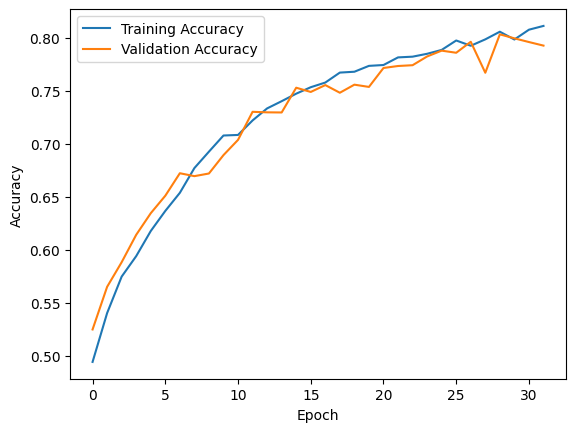

In [45]:
plt.plot(unidir_lstm_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(unidir_lstm_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 6.1.3 Evaluating Model

In [90]:
unidir_lstm_performance_matrices_dict = performance_matrices(
    unidir_lstm_model,
    X_train,
    X_test,
    y_train,
    y_test,
    verbose=True
)

313/313 [==============================] - 1s 3ms/step
Training Accuracy: 0.8115
Training Precision: 0.8132
Training Recall: 0.8078
Training F1 Score: 0.8105
Training AUC Score: 0.8115
--------------------------------------------------
Testing Accuracy:  0.8047
Testing Precision: 0.8107
Testing Recall: 0.7990
Testing F1 Score: 0.8048
Testing AUC Score: 0.8047


313/313 [==============================] - 1s 3ms/step


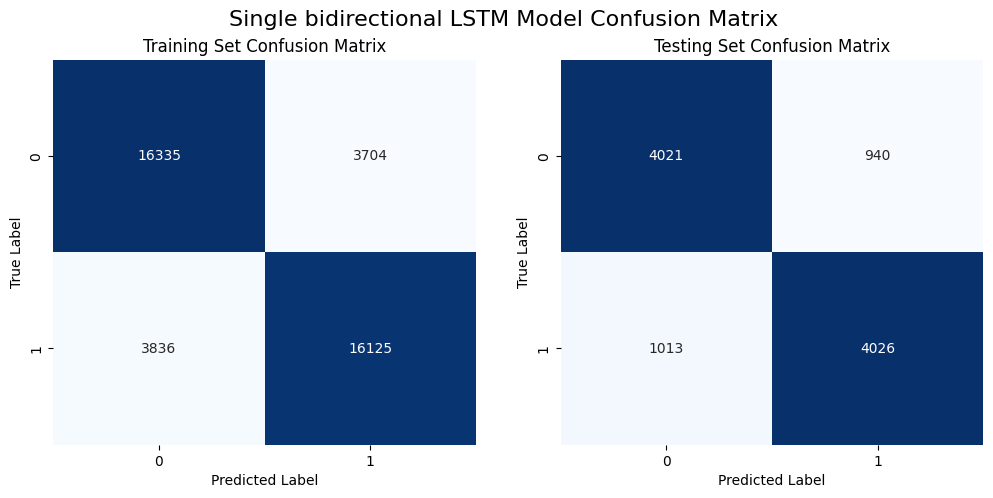

In [47]:
plot_confution_matrix(
    unidir_lstm_model,
    X_train,
    X_test,
    y_train,
    y_test,
    model_name='Single Unidirectional LSTM Model',
    show_img=True
)

313/313 [==============================] - 1s 3ms/step


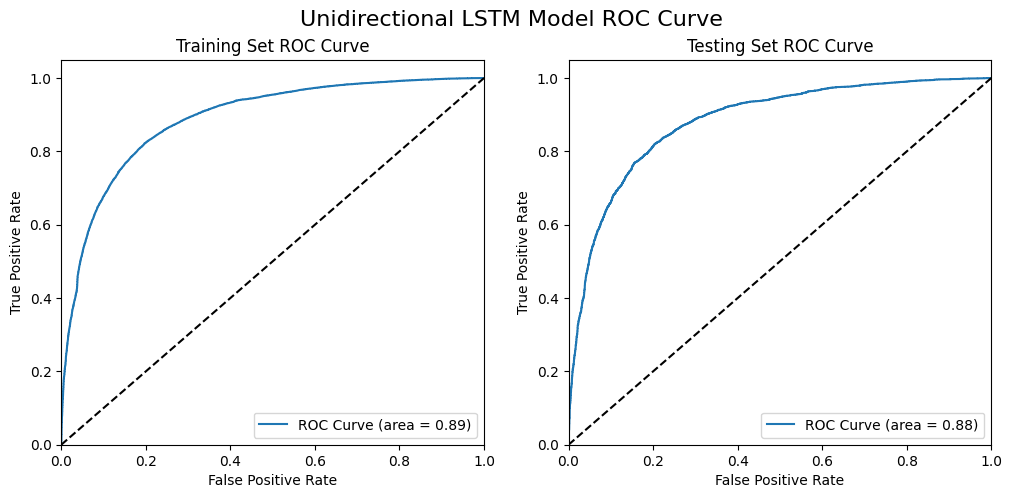

In [84]:
plot_roc_curve(
    unidir_lstm_model,
    X_train,
    X_test,
    y_train,
    y_test,
    model_name='Unidirectional LSTM Model',
    show_img=True
)

## 6.2. A single bidirectional LSTM layer

### 6.2.1. Model Defining

In [26]:
bidir_lstm_model = Sequential()

bidir_lstm_model.add(
    layers.Embedding(
        vocab_size,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=True
    )
)

bidir_lstm_model.add(layers.Bidirectional(layers.LSTM(10, activation='tanh')))
bidir_lstm_model.add(layers.Dense(1, activation='sigmoid'))

bidir_lstm_model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

bidir_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          12425300  
                                                                 
 bidirectional (Bidirection  (None, 20)                8880      
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 12434201 (47.43 MB)
Trainable params: 12434201 (47.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 6.2.2 Model Trainning

In [27]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [28]:
bidir_lstm_model_history = bidir_lstm_model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=True,
    validation_split=0.2,
    batch_size=4096,
    callbacks=[early_stopping]
)

Epoch 1/100
8/8 [==============================] - 7s 276ms/step - loss: 0.6953 - accuracy: 0.5140 - val_loss: 0.6887 - val_accuracy: 0.5395
Epoch 2/100
8/8 [==============================] - 1s 149ms/step - loss: 0.6845 - accuracy: 0.5544 - val_loss: 0.6801 - val_accuracy: 0.5721
Epoch 3/100
8/8 [==============================] - 2s 202ms/step - loss: 0.6748 - accuracy: 0.5831 - val_loss: 0.6683 - val_accuracy: 0.6041
Epoch 4/100
8/8 [==============================] - 2s 226ms/step - loss: 0.6619 - accuracy: 0.6105 - val_loss: 0.6513 - val_accuracy: 0.6341
Epoch 5/100
8/8 [==============================] - 2s 223ms/step - loss: 0.6385 - accuracy: 0.6447 - val_loss: 0.6721 - val_accuracy: 0.5881
Epoch 6/100
8/8 [==============================] - 2s 213ms/step - loss: 0.6284 - accuracy: 0.6520 - val_loss: 0.6062 - val_accuracy: 0.6812
Epoch 7/100
8/8 [==============================] - 1s 137ms/step - loss: 0.6072 - accuracy: 0.6767 - val_loss: 0.6079 - val_accuracy: 0.6722
Epoch 8/100
8

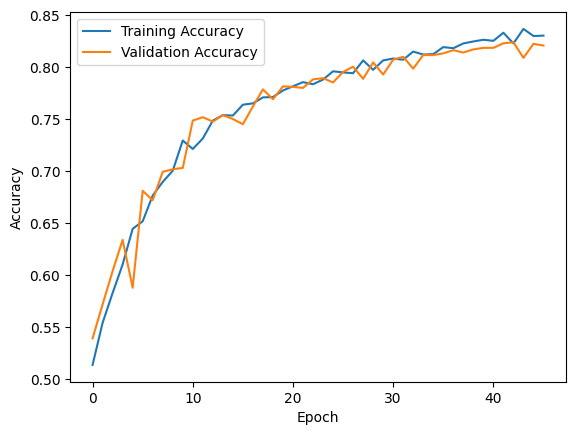

In [29]:
plt.plot(bidir_lstm_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(bidir_lstm_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 6.2.3 Evaluating Model

In [91]:
bidir_lstm_performance_matrices_dict = performance_matrices(
    bidir_lstm_model,
    X_train,
    X_test,
    y_train,
    y_test,
    verbose=True
)

313/313 [==============================] - 2s 6ms/step
Training Accuracy: 0.8361
Training Precision: 0.8509
Training Recall: 0.8143
Training F1 Score: 0.8322
Training AUC Score: 0.8361
--------------------------------------------------
Testing Accuracy:  0.8221
Testing Precision: 0.8400
Testing Recall: 0.7992
Testing F1 Score: 0.8191
Testing AUC Score: 0.8223


313/313 [==============================] - 2s 5ms/step


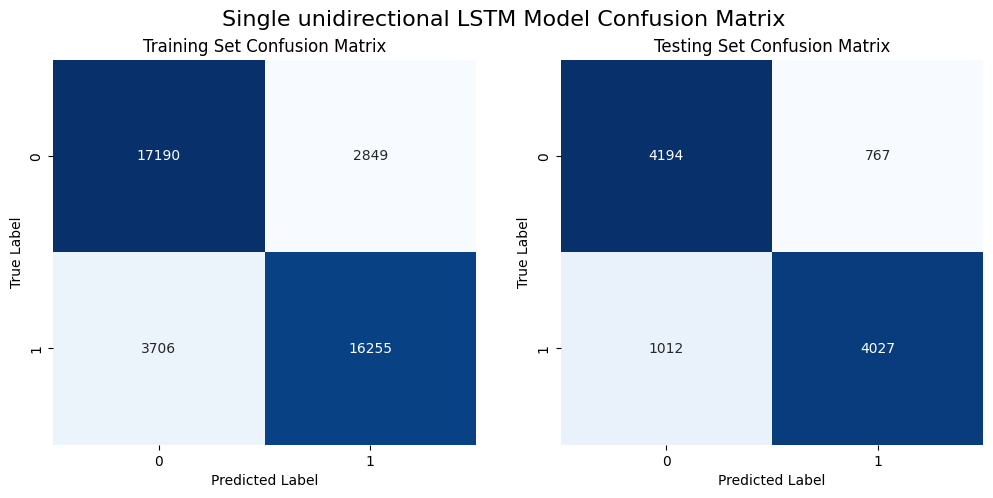

In [31]:
plot_confution_matrix(
    bidir_lstm_model,
    X_train,
    X_test,
    y_train,
    y_test,
    model_name='Single unidirectional LSTM Model',
    show_img=True
)

313/313 [==============================] - 1s 4ms/step


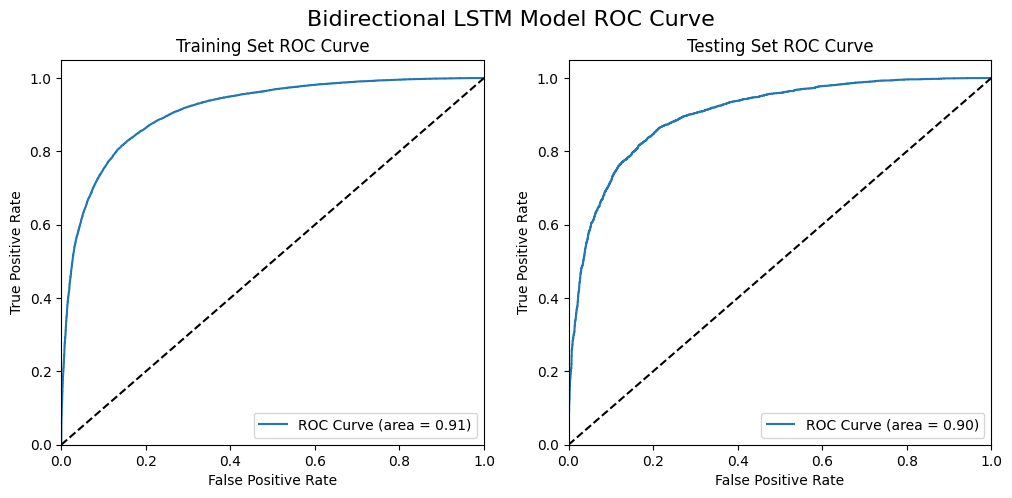

In [83]:
plot_roc_curve(
    bidir_lstm_model,
    X_train,
    X_test,
    y_train,
    y_test,
    model_name='Bidirectional LSTM Model',
    show_img=True
)

# Comparision of Models
### *7. Analyze the performance of these models with the original one. Which one is the best? Why is it the best? Suggest a couple of improvements so it can be better.*

In [98]:
cbc_lst = list(vi for k, v in cnb_performance_matrices_dict.items() for ki, vi in v.items())
swallow_lst = list(vi for k, v in performance_matrices_dict.items() for ki, vi in v.items())
unidir_lst = list(vi for k, v in unidir_lstm_performance_matrices_dict.items() for ki, vi in v.items())
bidir_lst = list(vi for k, v in bidir_lstm_performance_matrices_dict.items() for ki, vi in v.items())

# print performance matrices
print('Unidirectional LSTM Model Performance Matrices:')
print('|---------------------|-----------------------------------------------------------|-----------------------------------------------------------|')
print('|                     |                  Trainning                                |                   Testing                                 |')
print('|                     |-----------------------------------------------------------|-----------------------------------------------------------|')
print('|                     | Accuracy  | Precision | Recall    | F1        | AUC       | Accuracy  | Precision | Recall    | F1        | AUC       |')
print('|---------------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|')
print('| CNB Classifier      | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} |'.format(*cbc_lst))
print('| Shalllow Model      | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} |'.format(*swallow_lst))
print('| Unidirectional LSTM | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} |'.format(*unidir_lst))
print('| Bidirectional LSTM  | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} | {:9.04} |'.format(*bidir_lst))

Unidirectional LSTM Model Performance Matrices:
|---------------------|-----------------------------------------------------------|-----------------------------------------------------------|
|                     |                  Trainning                                |                   Testing                                 |
|                     |-----------------------------------------------------------|-----------------------------------------------------------|
|                     | Accuracy  | Precision | Recall    | F1        | AUC       | Accuracy  | Precision | Recall    | F1        | AUC       |
|---------------------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
| CNB Classifier      |    0.5235 |    0.5202 |     0.583 |    0.5498 |    0.5237 |    0.5149 |    0.5166 |    0.5807 |    0.5468 |    0.5144 |
| Shalllow Model      |    0.9117 |     0.927 |    0.8933 |    0.9099 |    0.9116 |    0